In [45]:
#импорт необходимых библиотек

import numpy as np
import pandas as pd
import os
import time
import datetime
from random import randint, seed

import seaborn as sns
import matplotlib.pyplot as plt

from tslearn.clustering import TimeSeriesKMeans, silhouette_score

from core_changed import Backtest, PlotPoint, IStrategy
from multiprocessing import Pool
from math import log
from datetime import datetime

In [46]:
total_path = 'C:\\Users\\Алексей\\Учеба\\ЦМФ\\Проекты\\Алготрейдинг\\Задание 6'
data_path = total_path + '\\stock_data'

## Загрузка результатов кластеризации, данных трейна и теста



выделяем только компактные кластера

In [78]:
train_df = pd.read_csv('train_and_clusters.csv')
test_df = pd.read_csv('test.csv')
test_df['label'] = train_df['label'].copy()

train_df = train_df[train_df['good_cluster']==1]
train_df.index = train_df['ticker']
good_tickers = list(train_df['ticker'])

good_tickers = list(train_df['ticker'])
test_df = test_df[test_df['ticker'].isin(good_tickers)]
test_df.index =  train_df['ticker']

feature_train_columns = list(train_df.columns)[1:-2]
feature_test_columns = list(test_df.columns)[1:-1]

## Стратегия
### Трейн

In [79]:
class Cluster_Pair_Stratagy(IStrategy):
    
    def __init__(self, total_invest_val, cluster_labels, log_flag):
        
        # Принимает общую величину инвестиций, лейблы кластеров тикеров, флаг способа рассчета доходностей. 
        # Лейблы кластеров должны идти в том же порядке, что и тикеры в feeds в функции 
        # make_desicion.
        
        self.total_invest_val = total_invest_val
        self.cluster_labels = cluster_labels
        self.cluster_names = list(set(cluster_labels['label']))
        self.one_cluster_investment = self.total_invest_val/len(self.cluster_names)
        self.log_flag = log_flag
    
    def get_columns_data_1_data_2(self, cluster_df, shift):
        # функция выделения названия колонок для data_2 и data_1.
        # Принимает: датафрейм со значениями цен активов в кластере, величину сдвига.
        # Возвращает: названия колонок, соответствующих data_1 и data_2.
        # Т.к. объект feeds (из которого формируется cluster_df) не хранит дат,
        # возвращаются номера колонок. 
        
        date_2 = list(cluster_df.columns)[-1]
        date_1 = list(cluster_df.columns)[-1*(shift+1)]
        return date_1, date_2
        
    def make_decision_one_cluster(self, cluster_number, feeds, shift, log_returns):
        # функция принятия решения по отдельному кластеру. 
        # Принимает номер кластераб словарь объектов класса feed, где ключи - название активов, 
        # значения - объекты класса feed, соответствующие тикеру, величину сдвига между data_1 и data_2.
        # Флаг log_returns определяет, какие доходности считаем. 
        # Класс feed определяется в core.py
        # Возвращает: словарь, где ключи -названия активов, значения - величины позиции по активу в кластере.
        
        
        # заглушка-проверка: берем первый тикер, если данных в нем недостаточно (меньше, 
        # чем расстояние между date_1 и date_2) - возвращаем пустой результат
        trial_ticker = list(feeds.keys())[0]
        if len(feeds[trial_ticker].close) < shift+1:
            return {}
        
        # выбираем тикеры и feeds, относящиеся к кластеру
        cluster_tickers = list(self.cluster_labels[self.cluster_labels['label'] == cluster_number].index)
        cluster_feeds = {i : feeds[i] for i in cluster_tickers}
        
        # преобразуем feeds в датафрейм
        cluster_df = pd.DataFrame()

        for i in cluster_tickers: 
            cluster_df[i] = cluster_feeds[i].close

        cluster_df = cluster_df.T
        
        # получаем даты, по которым считаем доходность
        date_1, date_2 = self.get_columns_data_1_data_2(cluster_df, shift)
        cluster_df = cluster_df[[date_1,date_2]]
        
        # cчитаем различные R
        if log_returns == True:
            cluster_df['R'] = np.log(cluster_df[date_2]/cluster_df[date_1])
        else:
            cluster_df['R'] = cluster_df[date_2]/cluster_df[date_1] - 1

        mean_R = np.mean(cluster_df['R'])
        cluster_df['R_tild'] = cluster_df['R'] - mean_R
        
        if np.sum(np.abs(cluster_df['R_tild'])) == 0:
            return {}
        
        # определяем веса, долларовый размер позиции D и количество активов в позиции Q. 
        gamma = self.one_cluster_investment/np.sum(np.abs(cluster_df['R_tild']))
        cluster_df['D'] = -1*gamma*cluster_df['R_tild']
        cluster_df['Q'] = cluster_df['D']/cluster_df[date_2]

        return dict(cluster_df['Q'])
        
    def make_decision(self, feeds):
        # функция принятия решения. Принимает словарь объектов feed, где ключи - название активов, 
        # значения - объекты класса feed, соответствующие тикеру. Класс feed определяется в core.py.
        # Возвращает: словарь, где ключи -названия активов, значения - величины позиции по активу. 
        
        results = {}
        shift = 1
        for i in self.cluster_names:
            positions = self.make_decision_one_cluster(i, feeds, shift, self.log_flag)
            results.update(positions)
        
        return results
    
    
    def get_plot_lines(self):
        # не написано, т.к. неясно, что строить
        return 0
    def get_plot_points(self):
        # не написано, т.к. неясно, что строить
        return 0
    
    
    
    def get_name(self):
        # ответ-заглушка
        return 'Strategy-Smile'

In [80]:
times_columns = feature_train_columns
cluster_column = 'label'

tickers = good_tickers

In [81]:
feeds = {i: pd.DataFrame({'Close':train_df[times_columns].T[i]}) for i in tickers}
cluster_labels = pd.DataFrame(train_df[cluster_column], columns = [cluster_column])

ticker_list = list(feeds.keys())

In [82]:
params = { 
    'total_invest_val':10000, 
    'cluster_labels': cluster_labels,
    'log_flag' : False
}

100%|████████████████████████████████████████████████████████████████████████████████| 393/393 [00:33<00:00, 11.82it/s]


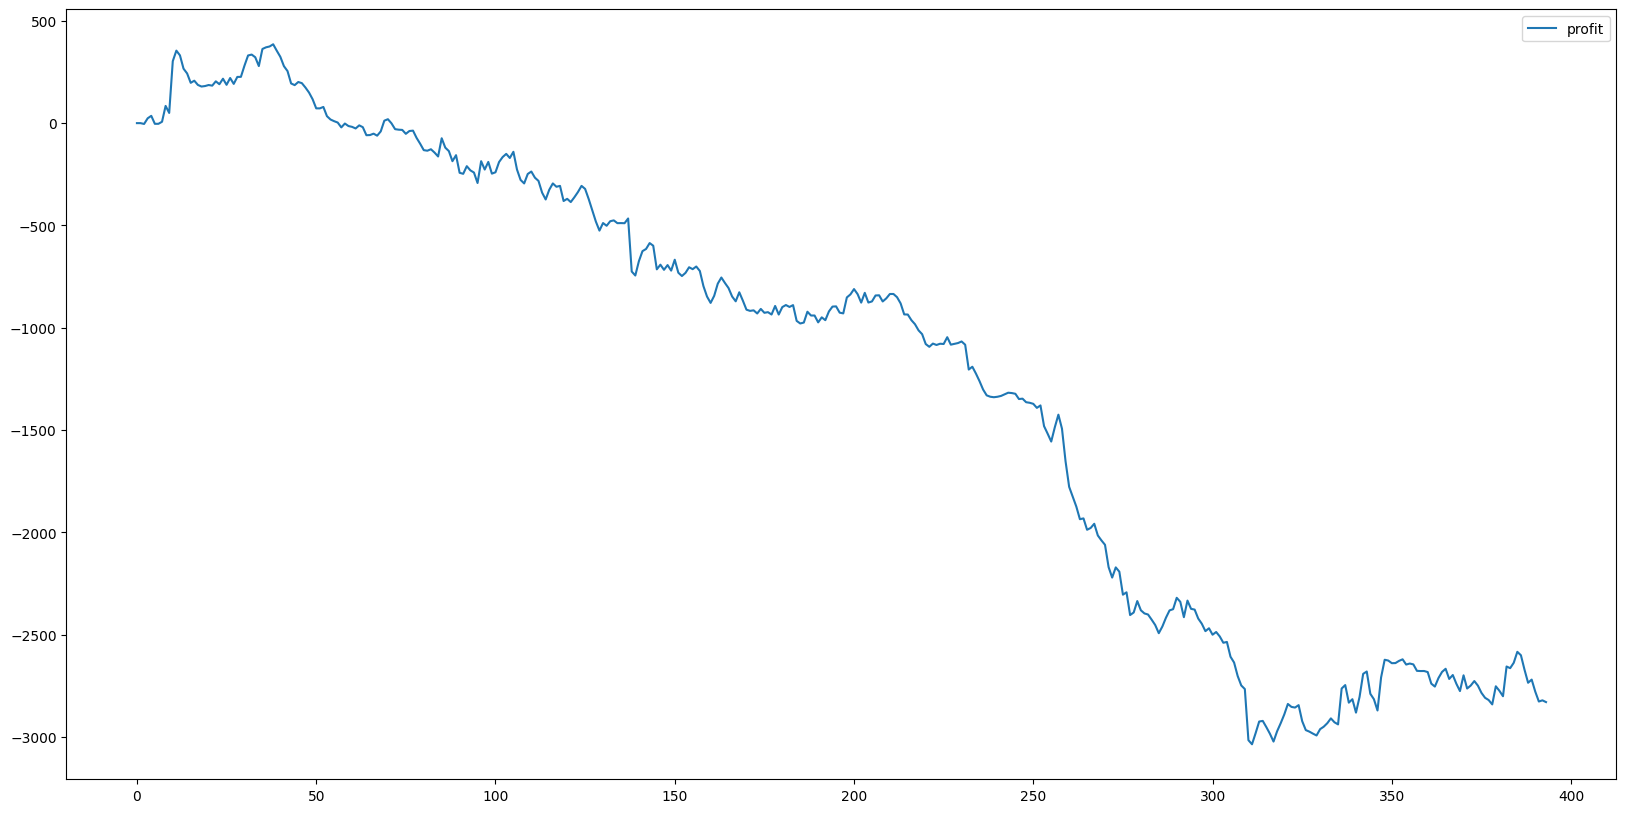

In [83]:
# функцию построения графиков акций отключил (в файле core.py, строка 180) т.к. не понятно, что строить

strategy = Cluster_Pair_Stratagy(**params)
bt = Backtest(feeds, strategy) # commision=0,0004
res, trades = bt.run(plot=True)

### Тест

In [84]:
times_columns = feature_test_columns
cluster_column = 'label'

tickers = good_tickers

In [85]:
feeds = {i: pd.DataFrame({'Close':test_df[times_columns].T[i]}) for i in tickers}
cluster_labels = pd.DataFrame(test_df[cluster_column], columns = [cluster_column])

ticker_list = list(feeds.keys())

In [86]:
params = { 
    'total_invest_val':10000, 
    'cluster_labels': cluster_labels,
    'log_flag' : False
}

100%|████████████████████████████████████████████████████████████████████████████████| 169/169 [00:13<00:00, 12.19it/s]


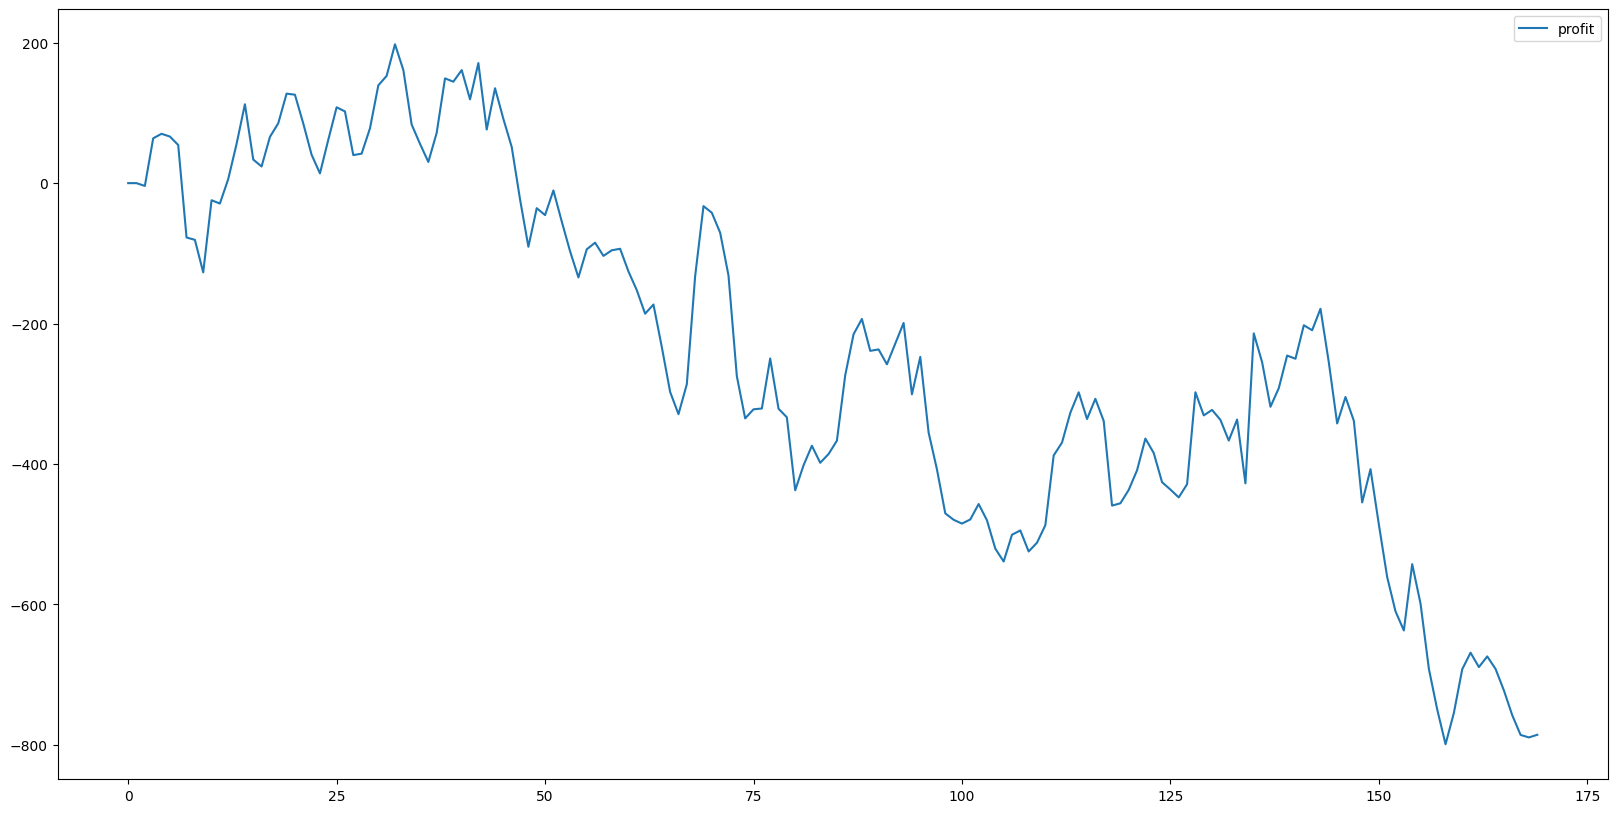

In [87]:
# функцию построения графиков акций отключил (в файле core.py, строка 180) т.к. не понятно, что строить

strategy = Cluster_Pair_Stratagy(**params)
bt = Backtest(feeds, strategy) # commision=0,0004
res, trades = bt.run(plot=True)